## Import Data ##

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [211]:
import torch
from torch_geometric.datasets import Amazon

dataset = Amazon(root="/tmp/Computers", name="Computers")
data = dataset[0]

num_samples = data.num_nodes
train_mask = torch.zeros(num_samples, dtype=torch.bool)
val_mask = torch.zeros(num_samples, dtype=torch.bool)
test_mask = torch.zeros(num_samples, dtype=torch.bool)

train_mask[:int(0.8 * num_samples)] = 1
val_mask[int(0.8 * num_samples):int(0.9 * num_samples)] = 1
test_mask[int(0.9 * num_samples):] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

## Statistical Modeling ##

In [213]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [215]:
pd_data.shape

(13752, 767)

In [217]:
pd_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,757,758,759,760,761,762,763,764,765,766
0,1.000000,0.392728,0.305402,0.364038,0.350929,0.396169,0.343974,0.339033,0.404636,0.345915,...,0.346516,0.364529,0.364023,0.355744,0.242519,0.396670,0.380568,0.380320,0.302050,0.363264
1,0.392728,1.000000,0.314634,0.358907,0.348422,0.381955,0.327859,0.306389,0.385328,0.332196,...,0.351099,0.370714,0.358734,0.377928,0.244635,0.409024,0.375244,0.377861,0.314347,0.395940
2,0.305402,0.314634,1.000000,0.321629,0.300236,0.322659,0.258709,0.334573,0.305400,0.286473,...,0.296779,0.307140,0.281536,0.296340,0.207734,0.318626,0.280973,0.308601,0.314188,0.304994
3,0.364038,0.358907,0.321629,1.000000,0.342078,0.368903,0.310204,0.297702,0.353002,0.348526,...,0.338365,0.331865,0.348530,0.351329,0.261450,0.381238,0.343753,0.359750,0.308182,0.356311
4,0.350929,0.348422,0.300236,0.342078,1.000000,0.358280,0.357231,0.355354,0.399668,0.395238,...,0.324681,0.265543,0.386636,0.334548,0.262650,0.365847,0.364505,0.328749,0.258450,0.345404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.396670,0.409024,0.318626,0.381238,0.365847,0.384975,0.337576,0.316026,0.383487,0.346167,...,0.352768,0.359296,0.382144,0.381324,0.255131,1.000000,0.388482,0.392764,0.317345,0.400708
763,0.380568,0.375244,0.280973,0.343753,0.364505,0.344630,0.351778,0.302285,0.390561,0.310344,...,0.313905,0.323659,0.374249,0.364020,0.247470,0.388482,1.000000,0.342748,0.271281,0.368644
764,0.380320,0.377861,0.308601,0.359750,0.328749,0.369384,0.301419,0.272157,0.350394,0.359275,...,0.370294,0.347851,0.357958,0.353809,0.270285,0.392764,0.342748,1.000000,0.341802,0.370546
765,0.302050,0.314347,0.314188,0.308182,0.258450,0.302993,0.242385,0.222493,0.266535,0.282783,...,0.308441,0.322148,0.276163,0.302470,0.182420,0.317345,0.271281,0.341802,1.000000,0.301194


In [218]:
pd_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,757,758,759,760,761,762,763,764,765,766
count,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,...,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000,13752.000000
mean,0.319154,0.362056,0.233130,0.262871,0.428301,0.251891,0.564282,0.417248,0.415721,0.204843,...,0.211097,0.206952,0.409540,0.426338,0.265343,0.340605,0.504727,0.243310,0.210806,0.357475
std,0.466145,0.480626,0.422845,0.440205,0.494841,0.434131,0.495871,0.493111,0.492871,0.403618,...,0.408101,0.405132,0.491764,0.494594,0.441527,0.473914,0.499982,0.429082,0.407886,0.479257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [450]:
def data_to_nx_subgraph(data, node_range):
    G = nx.Graph()
    
    start, end = node_range
    G.add_nodes_from(range(start, end))

    edge_index = data.edge_index
    edges = edge_index.t().tolist()

    filtered_edges = [
        (u, v) for u, v in edges if u >= start and u < end and v >= start and v < end
    ]

    G.add_edges_from(filtered_edges)

    cycles = list(nx.simple_cycles(G))

    nodes_in_cycles = set()
    for cycle in cycles:
        nodes_in_cycles.update(cycle)

    G.remove_nodes_from(nodes_in_cycles)

    return G

node_range = (0, 200)
G = data_to_nx_subgraph(data, node_range)

In [452]:
nx.cluster.average_clustering(G)

0.0

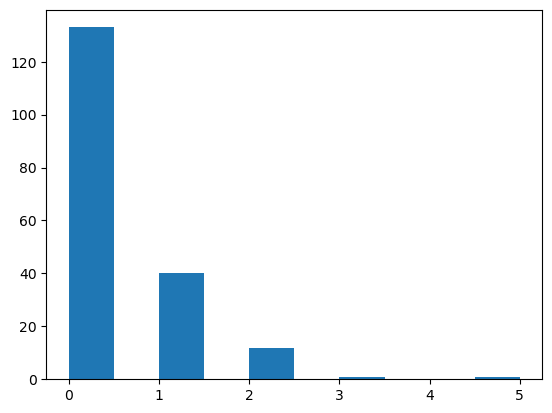

In [454]:
plt.hist([v for k, v in nx.degree(G)]);

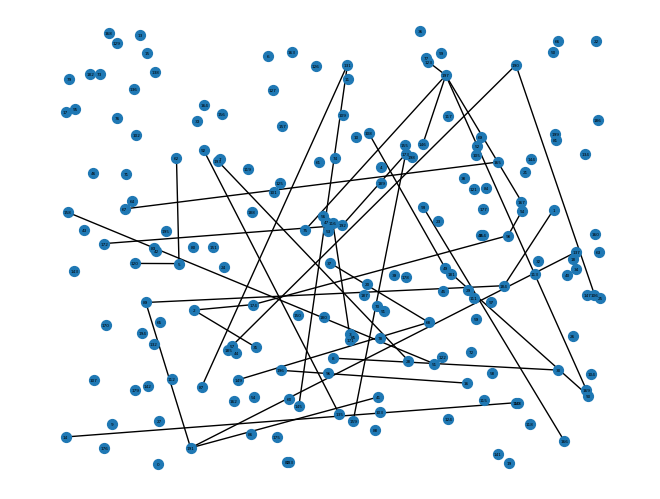

In [468]:
nx.draw_random(G, with_labels=True, node_size=50, font_size=3)
plt.show()

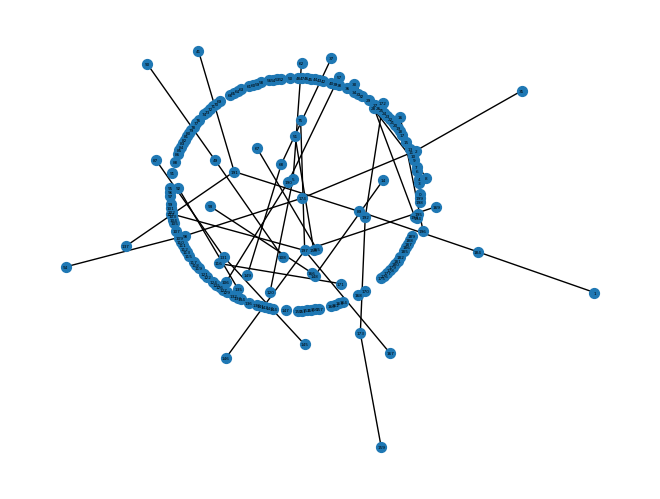

In [478]:
nx.draw_kamada_kawai(G, with_labels=True, node_size=50, font_size=3)

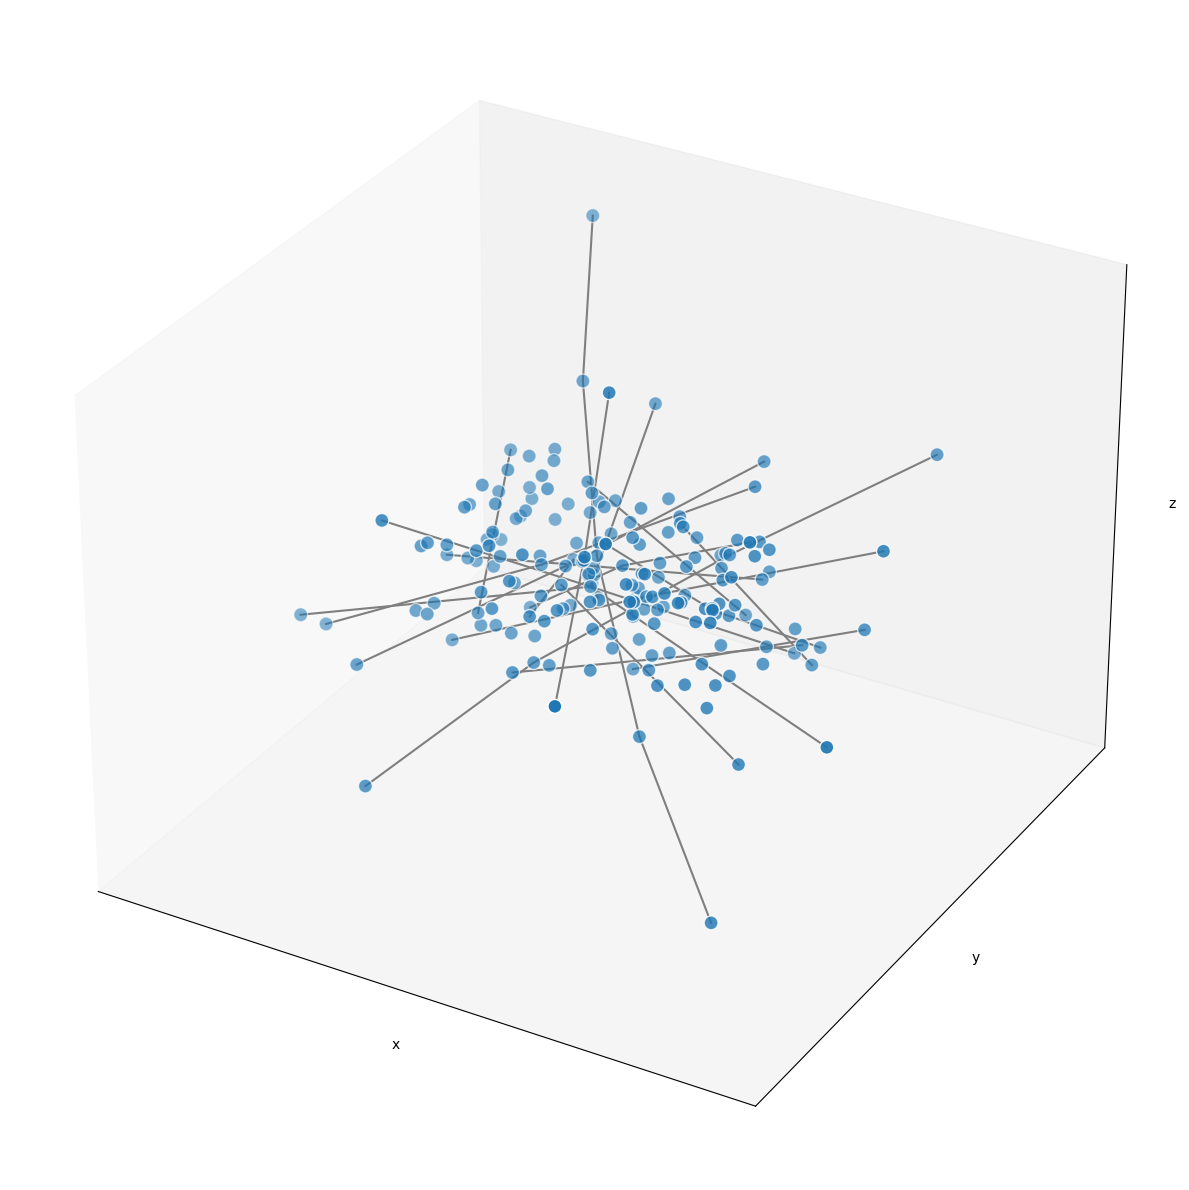

In [502]:
pos = nx.kamada_kawai_layout(G, dim=3)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(*node_xyz.T, s=100, ec="w")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    ax.grid(False)

    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

## Training Model ##

In [504]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [537]:
LR = 1e-04
HIDDEN = 64
EPOCHS = 400

In [538]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [539]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           64
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       49,088
├─GCNConv: 1-2                           10
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       640
Total params: 49,802
Trainable params: 49,802
Non-trainable params: 0

In [540]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [548]:
start_time = time.time()

for epoch in range(EPOCHS):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 0, Loss: 2.2994, Test Accuracy: 0.1715
Epoch: 10, Loss: 2.0654, Test Accuracy: 0.3561
Epoch: 20, Loss: 1.9462, Test Accuracy: 0.3590
Epoch: 30, Loss: 1.8733, Test Accuracy: 0.3844
Epoch: 40, Loss: 1.8156, Test Accuracy: 0.4368
Epoch: 50, Loss: 1.7649, Test Accuracy: 0.4462
Epoch: 60, Loss: 1.7195, Test Accuracy: 0.4702
Epoch: 70, Loss: 1.6730, Test Accuracy: 0.5015
Epoch: 80, Loss: 1.6262, Test Accuracy: 0.5087
Epoch: 90, Loss: 1.5809, Test Accuracy: 0.5305
Epoch: 100, Loss: 1.5338, Test Accuracy: 0.5669
Epoch: 110, Loss: 1.4866, Test Accuracy: 0.5996
Epoch: 120, Loss: 1.4422, Test Accuracy: 0.6330
Epoch: 130, Loss: 1.3983, Test Accuracy: 0.6606
Epoch: 140, Loss: 1.3544, Test Accuracy: 0.6860
Epoch: 150, Loss: 1.3136, Test Accuracy: 0.6999
Epoch: 160, Loss: 1.2756, Test Accuracy: 0.7137
Epoch: 170, Loss: 1.2399, Test Accuracy: 0.7188
Epoch: 180, Loss: 1.2062, Test Accuracy: 0.7253
Epoch: 190, Loss: 1.1744, Test Accuracy: 0.7318
Epoch: 200, Loss: 1.1442, Test Accuracy: 0.7384
Epo

## Post-Training Analysis ##

In [554]:
embeddings = []

def hook(module, input, output):
    embeddings.append(output.detach().cpu())

model.conv2.register_forward_hook(hook)

model.eval()
out = model(data.x, data.edge_index)

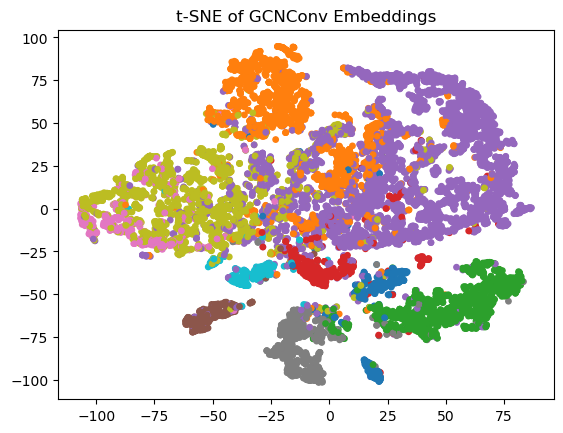

In [556]:
z = TSNE(n_components=2).fit_transform(embeddings[0].numpy())
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

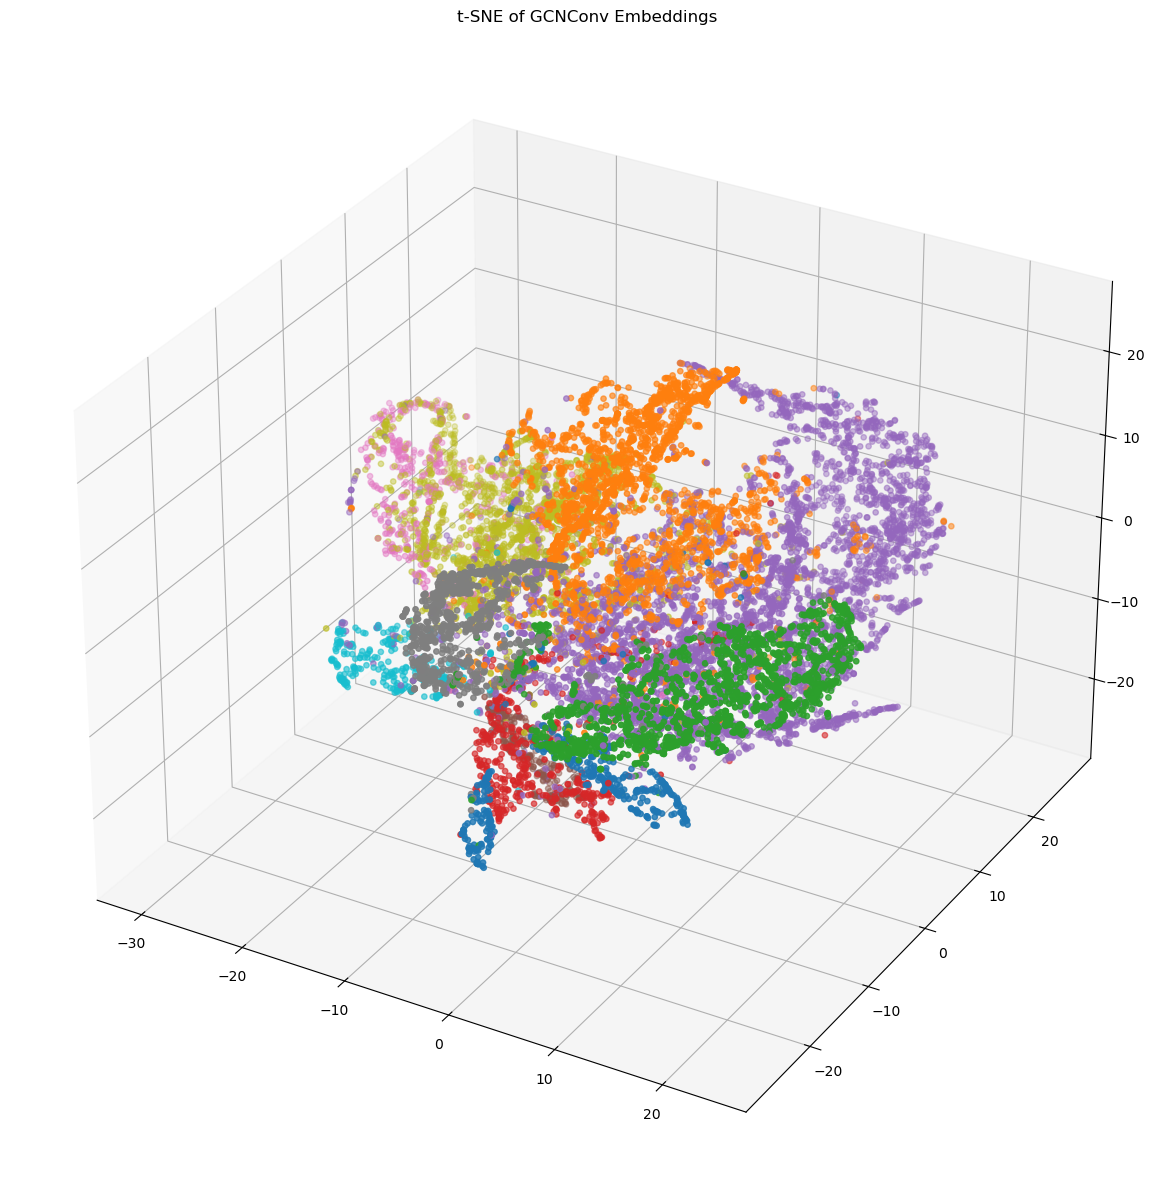

In [557]:
z = TSNE(n_components=3).fit_transform(embeddings[0].numpy())

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

In [558]:
probs = F.softmax(out, dim=1)
confidence, pred_class = probs.max(dim=1)

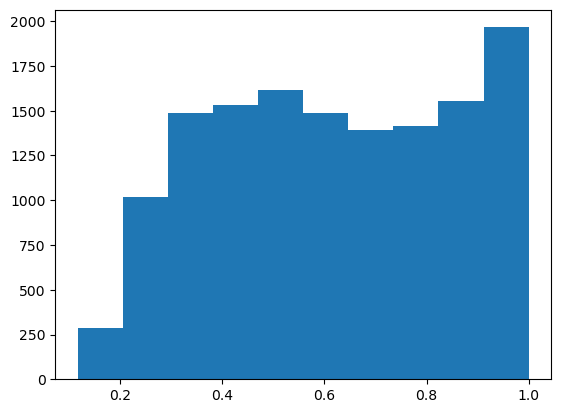

In [559]:
plt.hist(confidence.detach().numpy())
plt.show()

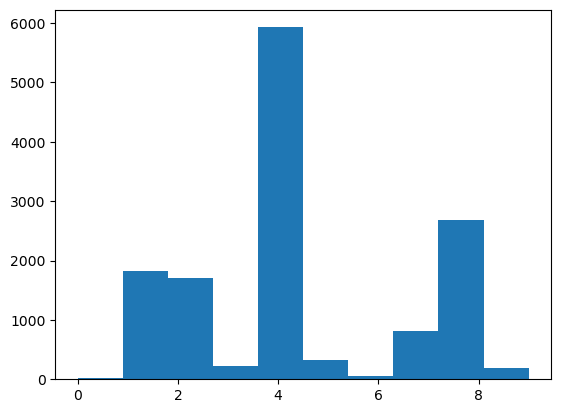

In [560]:
plt.hist(pred_class)
plt.show()

In [561]:
wrong = (pred_class != data.y).cpu()
wrong_nodes = torch.nonzero(wrong).flatten()

print(f"Number of Misclassified Nodes: {len(wrong_nodes.tolist())}")

Number of Misclassified Nodes: 2637


In [562]:
torch.save(model.state_dict(), "Amazon.pth")

In [563]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("Amazon.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(767, 64)
  (conv2): GCNConv(64, 10)
)